# German Energy Price Forecasting: Exploratory Data Analysis (EDA)


---


## Introduction


This notebook presents an exploratory data analysis (EDA) of the German energy market datasets, focusing on actual generation and day-ahead prices. The goal is to understand the data, identify patterns, and prepare for predictive modeling.


---


## Table of Contents


0. [Introduction](#introduction)
1. [Import Libraries](#1.-import-libraries)
2. [Data Loading](#2.-data-loading)
3. [Initial Data Inspection](#3.-initial-data-inspection)
4. [Data Cleaning](#4.-data-cleaning)
5. [Feature Engineering](#5-feature-engineering)
6. [Univariate Analysis](#6.-univariate-analysis)
7. [Bivariate/Multivariate Analysis](#7-bivariatemultivariate-analysis)
8. [Insights and Observations](#Insights-and-Observations)
9. [Next Steps / Conclusion](#Next-Steps--Conclusion)

## 1. Import Libraries

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data Loading

In [157]:
# Load the raw datasets for actual generation and day-ahead prices
df_path_gen = '../data/raw/Actual_generation_202101010000_202509180000_Hour.csv'
df_path_price = '../data/raw/Day-ahead_prices_202101010000_202509180000_Hour.csv'

actual_generation = pd.read_csv(
    df_path_gen, 
    sep=';', 
    low_memory=False,
    na_values=['-']
)
day_ahead_prices = pd.read_csv(
    df_path_price, 
    sep=';', 
    low_memory=False,
    na_values=['-']
)

## 3. Initial Data Inspection

In [158]:
print(actual_generation.shape)
actual_generation.info()
actual_generation.head()

(41303, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41303 entries, 0 to 41302
Data columns (total 14 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Start date                                         41303 non-null  object 
 1   End date                                           41303 non-null  object 
 2   Biomass [MWh] Calculated resolutions               41300 non-null  object 
 3   Hydropower [MWh] Calculated resolutions            41300 non-null  object 
 4   Wind offshore [MWh] Calculated resolutions         41300 non-null  object 
 5   Wind onshore [MWh] Calculated resolutions          41300 non-null  object 
 6   Photovoltaics [MWh] Calculated resolutions         41300 non-null  object 
 7   Other renewable [MWh] Calculated resolutions       41300 non-null  float64
 8   Nuclear [MWh] Calculated resolutions               26988 non-null  object 

,Start date,End date,Biomass [MWh] Calculated resolutions,Hydropower [MWh] Calculated resolutions,Wind offshore [MWh] Calculated resolutions,Wind onshore [MWh] Calculated resolutions,Photovoltaics [MWh] Calculated resolutions,Other renewable [MWh] Calculated resolutions,Nuclear [MWh] Calculated resolutions,Lignite [MWh] Calculated resolutions,Hard coal [MWh] Calculated resolutions,Fossil gas [MWh] Calculated resolutions,Hydro pumped storage [MWh] Calculated resolutions,Other conventional [MWh] Calculated resolutions
0,"Jan 1, 2021 12:00 AM","Jan 1, 2021 1:00 AM","4,481.00","1,203.00",383.00,"3,928.25",1.00,213.00,"8,144.75","11,608.50","3,443.75","6,923.00",347.25,"1,637.50"
1,"Jan 1, 2021 1:00 AM","Jan 1, 2021 2:00 AM","4,453.00","1,192.75",394.50,"3,528.25",1.00,213.25,"8,150.25","11,602.75","3,044.75","6,688.00",518.50,"1,636.00"
2,"Jan 1, 2021 2:00 AM","Jan 1, 2021 3:00 AM","4,440.50","1,161.00",305.25,"3,198.00",1.00,216.50,"8,156.50","11,758.50","3,067.25","6,586.00",170.00,"1,630.00"
3,"Jan 1, 2021 3:00 AM","Jan 1, 2021 4:00 AM","4,424.75","1,177.75",319.25,"2,768.75",1.00,218.00,"8,153.75","12,337.50","2,852.50","6,396.50",2.00,"1,621.50"
4,"Jan 1, 2021 4:00 AM","Jan 1, 2021 5:00 AM","4,430.75","1,153.25",296.25,"2,462.25",1.00,221.50,"8,150.50","12,395.00","2,713.25","6,333.00",6.00,"1,621.50"


In [159]:
# Data Inspection (continued)
print(day_ahead_prices.shape)
day_ahead_prices.info()
day_ahead_prices.head()

(41303, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41303 entries, 0 to 41302
Data columns (total 19 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Start date                                       41303 non-null  object 
 1   End date                                         41303 non-null  object 
 2   Germany/Luxembourg [€/MWh] Original resolutions  41303 non-null  float64
 3   ∅ DE/LU neighbours [€/MWh] Original resolutions  41207 non-null  float64
 4   Belgium [€/MWh] Original resolutions             41303 non-null  float64
 5   Denmark 1 [€/MWh] Original resolutions           41303 non-null  float64
 6   Denmark 2 [€/MWh] Original resolutions           41303 non-null  float64
 7   France [€/MWh] Original resolutions              41303 non-null  object 
 8   Netherlands [€/MWh] Original resolutions         41303 non-null  float64
 9   Norway 2 [€/MWh]

,Start date,End date,Germany/Luxembourg [€/MWh] Original resolutions,∅ DE/LU neighbours [€/MWh] Original resolutions,Belgium [€/MWh] Original resolutions,Denmark 1 [€/MWh] Original resolutions,Denmark 2 [€/MWh] Original resolutions,France [€/MWh] Original resolutions,Netherlands [€/MWh] Original resolutions,Norway 2 [€/MWh] Original resolutions,Austria [€/MWh] Original resolutions,Poland [€/MWh] Original resolutions,Sweden 4 [€/MWh] Original resolutions,Switzerland [€/MWh] Original resolutions,Czech Republic [€/MWh] Original resolutions,DE/AT/LU [€/MWh] Original resolutions,Northern Italy [€/MWh] Calculated resolutions,Slovenia [€/MWh] Original resolutions,Hungary [€/MWh] Original resolutions
0,"Jan 1, 2021 12:00 AM","Jan 1, 2021 1:00 AM",50.87,44.17,50.87,50.87,50.87,50.87,50.87,24.95,50.87,34.18,24.95,50.98,45.54,NaN,50.87,50.87,45.54
1,"Jan 1, 2021 1:00 AM","Jan 1, 2021 2:00 AM",48.19,41.63,48.19,48.19,48.19,48.19,48.19,24.35,48.19,32.61,24.35,45.94,41.59,NaN,48.19,48.19,41.59
2,"Jan 1, 2021 2:00 AM","Jan 1, 2021 3:00 AM",44.68,39.38,44.68,44.68,44.68,44.68,44.68,23.98,44.68,32.58,23.98,44.53,40.05,NaN,44.68,44.68,40.05
3,"Jan 1, 2021 3:00 AM","Jan 1, 2021 4:00 AM",42.92,37.73,42.92,42.92,42.92,42.92,42.92,23.72,42.92,32.20,23.72,41.01,36.90,NaN,42.92,42.92,36.90
4,"Jan 1, 2021 4:00 AM","Jan 1, 2021 5:00 AM",40.39,35.70,40.39,40.39,40.39,40.39,40.39,23.73,40.39,29.16,23.73,39.23,34.47,NaN,40.39,40.39,34.47


In [160]:
# Looking for missing values
print("Missing values in each dataset:")
print("Actual Generation:")
print(actual_generation.isnull().sum())
print("Day Ahead Prices:")
print(day_ahead_prices.isnull().sum())

Missing values in each dataset:
Actual Generation:
Start date                                               0
End date                                                 0
Biomass [MWh] Calculated resolutions                     3
Hydropower [MWh] Calculated resolutions                  3
Wind offshore [MWh] Calculated resolutions               3
Wind onshore [MWh] Calculated resolutions                3
Photovoltaics [MWh] Calculated resolutions               3
Other renewable [MWh] Calculated resolutions             3
Nuclear [MWh] Calculated resolutions                 14315
Lignite [MWh] Calculated resolutions                    28
Hard coal [MWh] Calculated resolutions                  28
Fossil gas [MWh] Calculated resolutions                  3
Hydro pumped storage [MWh] Calculated resolutions        3
Other conventional [MWh] Calculated resolutions         28
dtype: int64
Day Ahead Prices:
Start date                                             0
End date                           

### Initial Data Summary

- Both datasets have 41,303 rows.
- Several columns have missing values:
  - "Nuclear [MWh]" (actual generation) has many missing values, due to the permanent shutdown of remaining nuclear reactors in Germany since April 16, 2023.
   
  - "DE/AT/LU [€/MWh]" (day-ahead prices) is entirely missing.
- Most numeric columns are stored as objects and need conversion.
- No missing values in date columns.

Next: Convert data types and handle missing values.

## 4. Data Cleaning

### Data Cleaning Summary

- Dropped Duplicates if any existed
- All date columns are converted to datetime objects for easier time-based analysis.
- Numeric columns with commas and '-' placeholders are cleaned and converted to floats; missing values are handled appropriately.
- For `actual_generation`, missing values are filled with 0, assuming missing means no generation for that period.
- For `day_ahead_prices`, missing values are interpolated to maintain continuity in the time series, and empty columns are dropped.

**Observation:**

- The datasets required significant cleaning to ensure consistency and usability for time series analysis. Handling missing values and proper type conversion are crucial for downstream analysis.


In [161]:
# Remove duplicates if any
actual_generation = actual_generation.drop_duplicates()
day_ahead_prices = day_ahead_prices.drop_duplicates()

# Convert 'Start date' and 'End date' columns to datetime objects for both datasets
date_format = "%b %d, %Y %I:%M %p"

actual_generation['Start date'] = pd.to_datetime(actual_generation['Start date'], format=date_format)
actual_generation['End date'] = pd.to_datetime(actual_generation['End date'], format=date_format)
day_ahead_prices['Start date'] = pd.to_datetime(day_ahead_prices['Start date'], format=date_format)
day_ahead_prices['End date'] = pd.to_datetime(day_ahead_prices['End date'], format=date_format)

# Delete rows with Start date >= 2025-09-17 (incomplete day)
actual_generation = actual_generation[actual_generation['Start date'] < '2025-09-17']
day_ahead_prices = day_ahead_prices[day_ahead_prices['Start date'] < '2025-09-17']

In [162]:
# Convert all object columns to float after removing commas
for df in [actual_generation, day_ahead_prices]:
    for col in df.select_dtypes(include=['object']).columns:
        # Remove commas and convert to float
        df[col] = df[col].str.replace(',', '').astype(float)

In [163]:
# Handle missing values in both datasets
# For actual_generation: replace all missing values with 0 (assume no generation)
actual_generation.fillna(0, inplace=True)

# For day_ahead_prices: interpolate missing values, and drop empty columns
day_ahead_prices.dropna(axis=1, how='all', inplace=True)
day_ahead_prices.interpolate(method='linear', inplace=True)

# Sanity check for missing values
print('Any missing values in actual_generation?', actual_generation.isnull().values.any())
print('Any missing values in day_ahead_prices?', day_ahead_prices.isnull().values.any())

Any missing values in actual_generation? False
Any missing values in day_ahead_prices? False


## 5. Feature Engineering

In [164]:
# Helper function to assign season based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

#### Actual Generation Dataset

In [165]:
# Add a column for total generation (sum across all generation types)
actual_generation['Total Generation [MWh]'] = actual_generation.\
    drop(columns=['Start date', 'End date']).sum(axis=1)

# Extract temporal features from 'Start date'
actual_generation['year'] = actual_generation["Start date"].dt.year
actual_generation['season'] = actual_generation["Start date"].dt.month.apply(get_season).astype('category')
actual_generation['month'] = actual_generation["Start date"].dt.month.astype('category')
actual_generation['day_of_week'] = actual_generation["Start date"].dt.day_name().astype('category')
actual_generation['hour'] = actual_generation["Start date"].dt.hour.astype('category')

#### Day-Ahead Prices Dataset

In [166]:
# Add columns for year, month, season, and day of week
day_ahead_prices['year'] = day_ahead_prices["Start date"].dt.year
day_ahead_prices['season'] = day_ahead_prices["Start date"].dt.month.apply(get_season).astype('category')
day_ahead_prices['month'] = day_ahead_prices["Start date"].dt.month.astype('category')
day_ahead_prices['day_of_week'] = day_ahead_prices["Start date"].dt.day_name().astype('category')
day_ahead_prices['hour'] = day_ahead_prices["Start date"].dt.hour.astype('category')


In [167]:
# TODO: Include in the data Viz section instead
# Display summary statistics for the target variable
day_ahead_prices["Germany/Luxembourg [€/MWh] Original resolutions"].describe()

count    41279.000000
mean       120.676913
std        102.910714
min       -500.000000
25%         65.030000
50%         96.000000
75%        140.730000
max        936.280000
Name: Germany/Luxembourg [€/MWh] Original resolutions, dtype: float64

## 6. Univariate Analysis


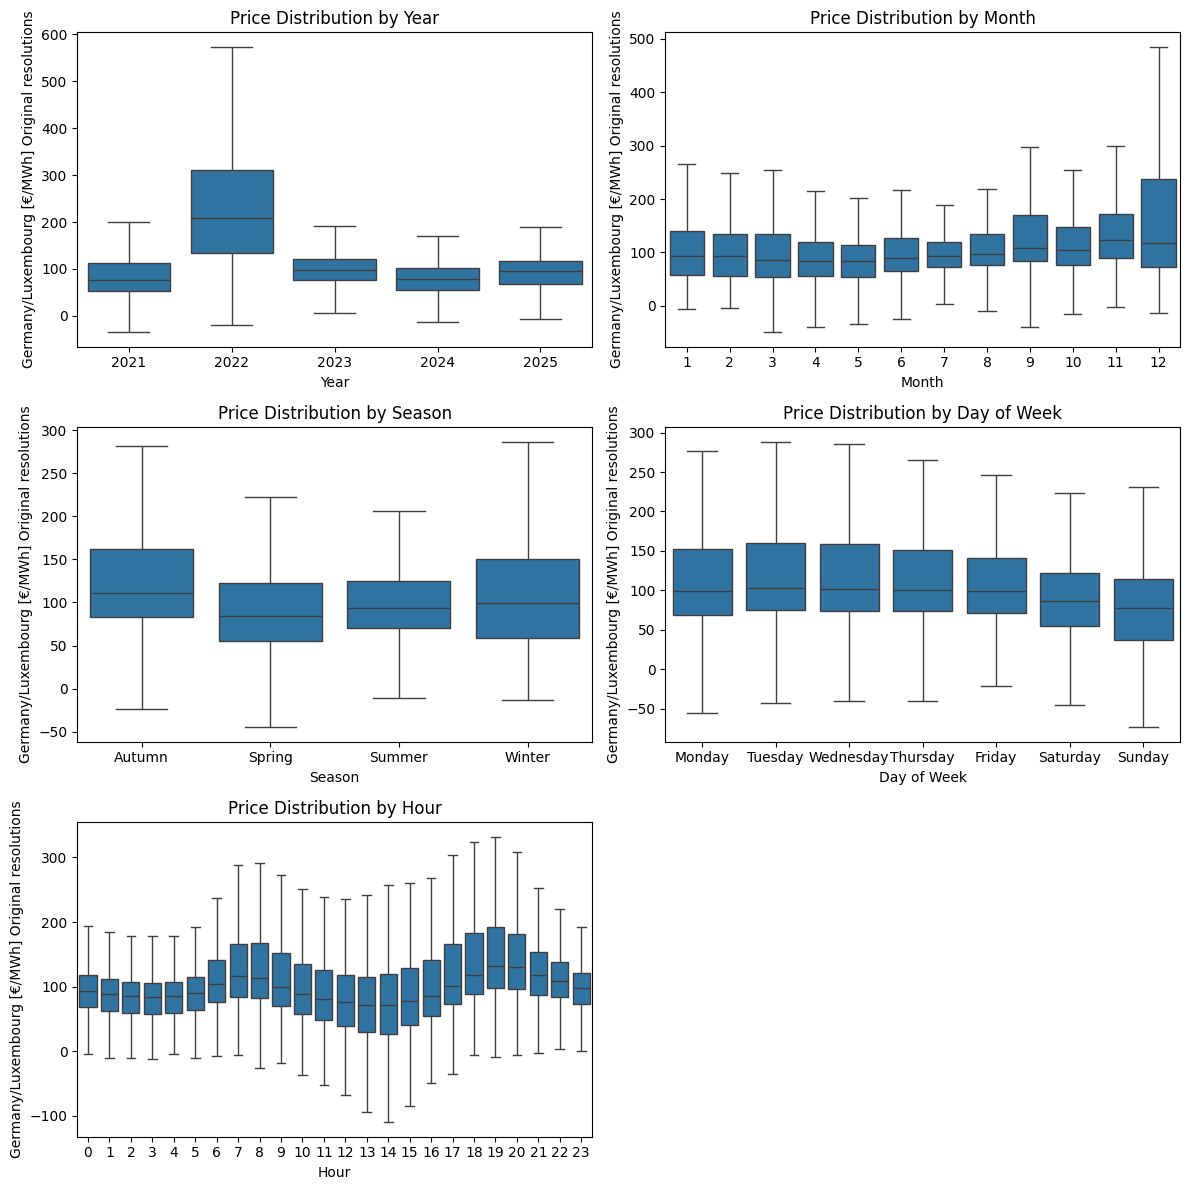

In [168]:
# Box plots to visualize price distribution by year, month, season, and day of the week

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Box plot for price by year
sns.boxplot(
    ax=axes[0, 0], 
    x='year', 
    y='Germany/Luxembourg [€/MWh] Original resolutions', 
    data=day_ahead_prices,
    showfliers=False
)
axes[0, 0].set_title('Price Distribution by Year')
axes[0, 0].set_xlabel('Year')

# Box plot for price by month
sns.boxplot(
    ax=axes[0, 1], 
    x='month', 
    y='Germany/Luxembourg [€/MWh] Original resolutions', 
    data=day_ahead_prices, 
    showfliers=False
)
axes[0, 1].set_title('Price Distribution by Month')
axes[0, 1].set_xlabel('Month')

# Box plot for price by season
sns.boxplot(
    ax=axes[1, 0], 
    x='season', 
    y='Germany/Luxembourg [€/MWh] Original resolutions', 
    data=day_ahead_prices, 
    showfliers=False
)
axes[1, 0].set_title('Price Distribution by Season')
axes[1, 0].set_xlabel('Season')

# Box plot for price by day of the week
sns.boxplot(
    ax=axes[1, 1], 
    x='day_of_week', 
    y='Germany/Luxembourg [€/MWh] Original resolutions', 
    data=day_ahead_prices, 
    order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    showfliers=False
)
axes[1, 1].set_title('Price Distribution by Day of Week')
axes[1, 1].set_xlabel('Day of Week')

# Box plot for price by hour
sns.boxplot(
    ax=axes[2, 0], 
    x='hour', 
    y='Germany/Luxembourg [€/MWh] Original resolutions', 
    data=day_ahead_prices, 
    showfliers=False
)
axes[2, 0].set_title('Price Distribution by Hour')
axes[2, 0].set_xlabel('Hour')
# Remove empty subplot
axes[2, 1].remove()

plt.tight_layout()
plt.show()

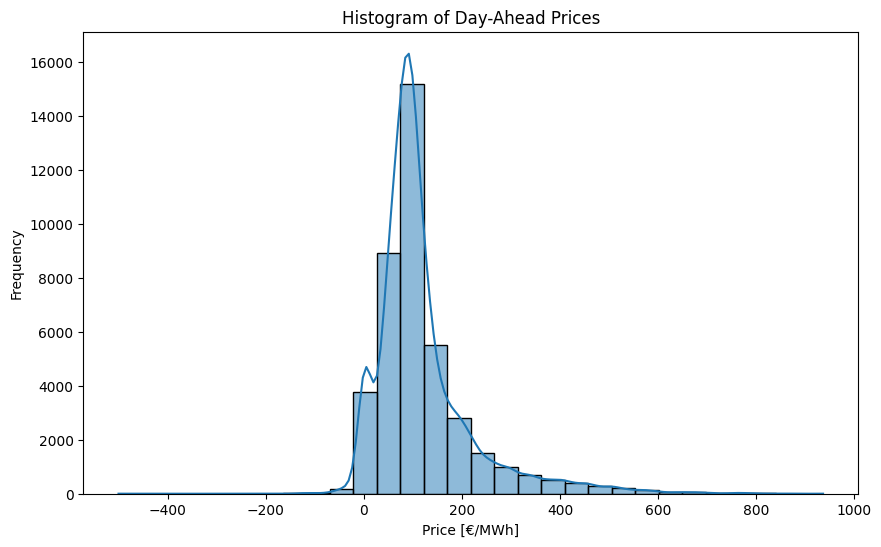

In [174]:
# Histogram of day-ahead prices
plt.figure(figsize=(10, 6))
sns.histplot(day_ahead_prices['Germany/Luxembourg [€/MWh] Original resolutions'], bins=30, kde=True)
plt.title('Histogram of Day-Ahead Prices')
plt.xlabel('Price [€/MWh]')
plt.ylabel('Frequency')
plt.show()

#### Observation

- December and autumn months show the highest day-ahead prices, indicating possible seasonal effects.
- Prices are generally lower on weekends compared to weekdays, suggesting demand patterns influence price.


### Result:

- December has the highest day-ahead prices, and autumn is the most expensive season.
- Weekends consistently show lower prices, likely due to reduced industrial demand.
- These patterns highlight the importance of seasonality and weekly cycles in electricity price forecasting.


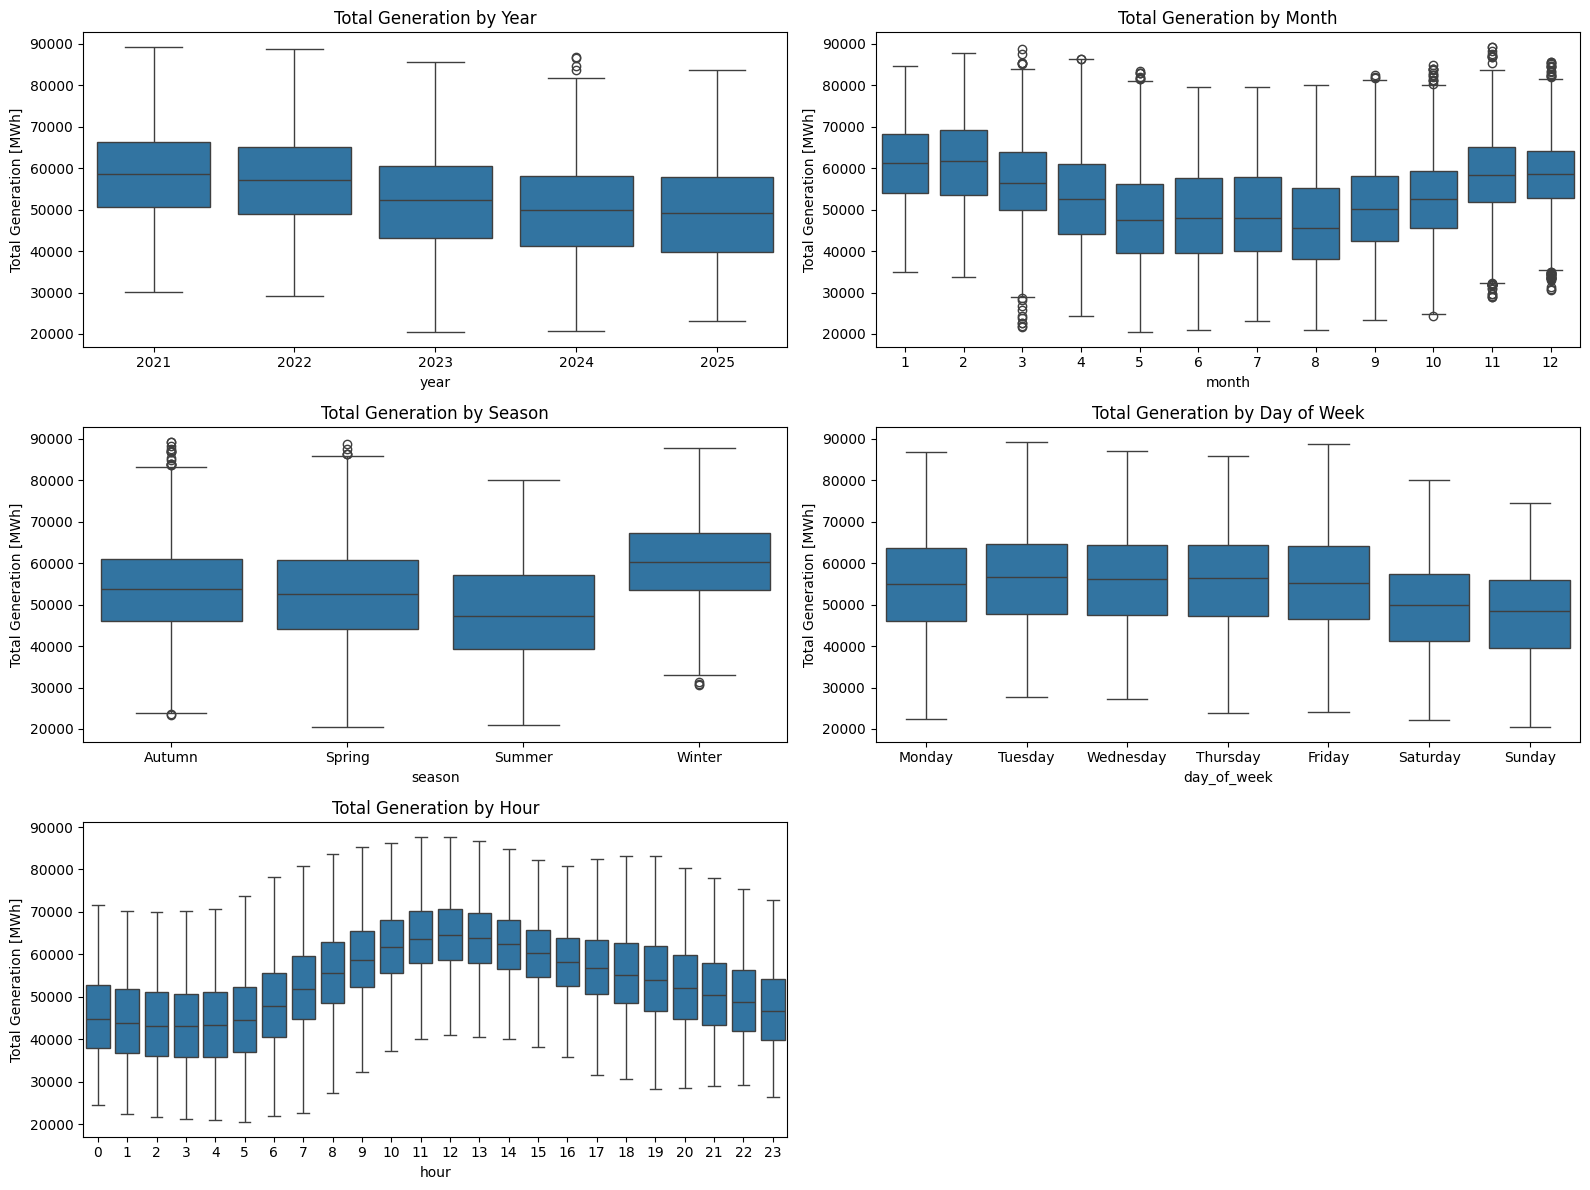

In [169]:
# box plots to visualize total generation distribution by year, month, season, and day of the week
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
sns.boxplot(x='year', y='Total Generation [MWh]', data=actual_generation)
plt.title('Total Generation by Year')

plt.subplot(3, 2, 2)
sns.boxplot(x='month', y='Total Generation [MWh]', data=actual_generation)
plt.title('Total Generation by Month')

plt.subplot(3, 2, 3)
sns.boxplot(x='season', y='Total Generation [MWh]', data=actual_generation)
plt.title('Total Generation by Season')

plt.subplot(3, 2, 4)
sns.boxplot(x='day_of_week', y='Total Generation [MWh]', data=actual_generation,
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Total Generation by Day of Week')

plt.subplot(3, 2, 5)
sns.boxplot(x='hour', y='Total Generation [MWh]', data=actual_generation, showfliers=False)
plt.title('Total Generation by Hour')

plt.tight_layout()
plt.show()

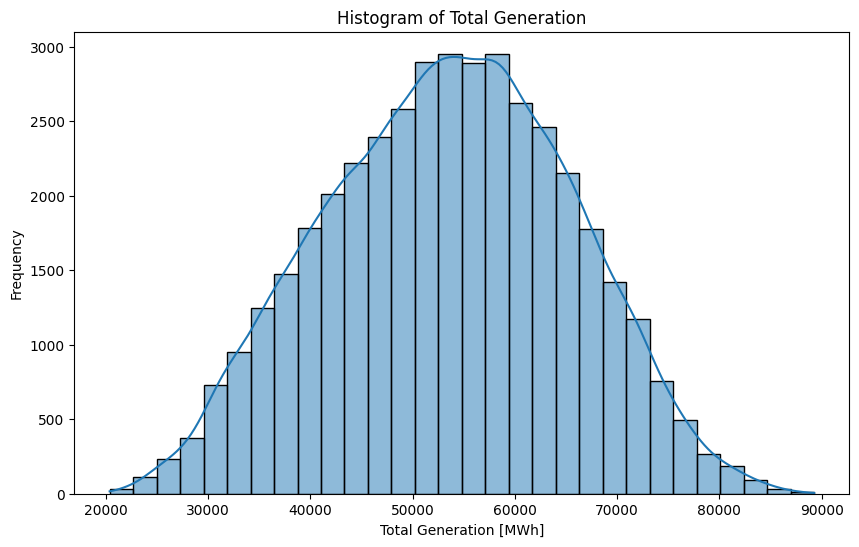

In [175]:
# Histogram of total generation
plt.figure(figsize=(10, 6))
sns.histplot(actual_generation['Total Generation [MWh]'], bins=30, kde=True)
plt.title('Histogram of Total Generation')
plt.xlabel('Total Generation [MWh]')
plt.ylabel('Frequency')
plt.show()

## 7. Bivariate/Multivariate Analysis

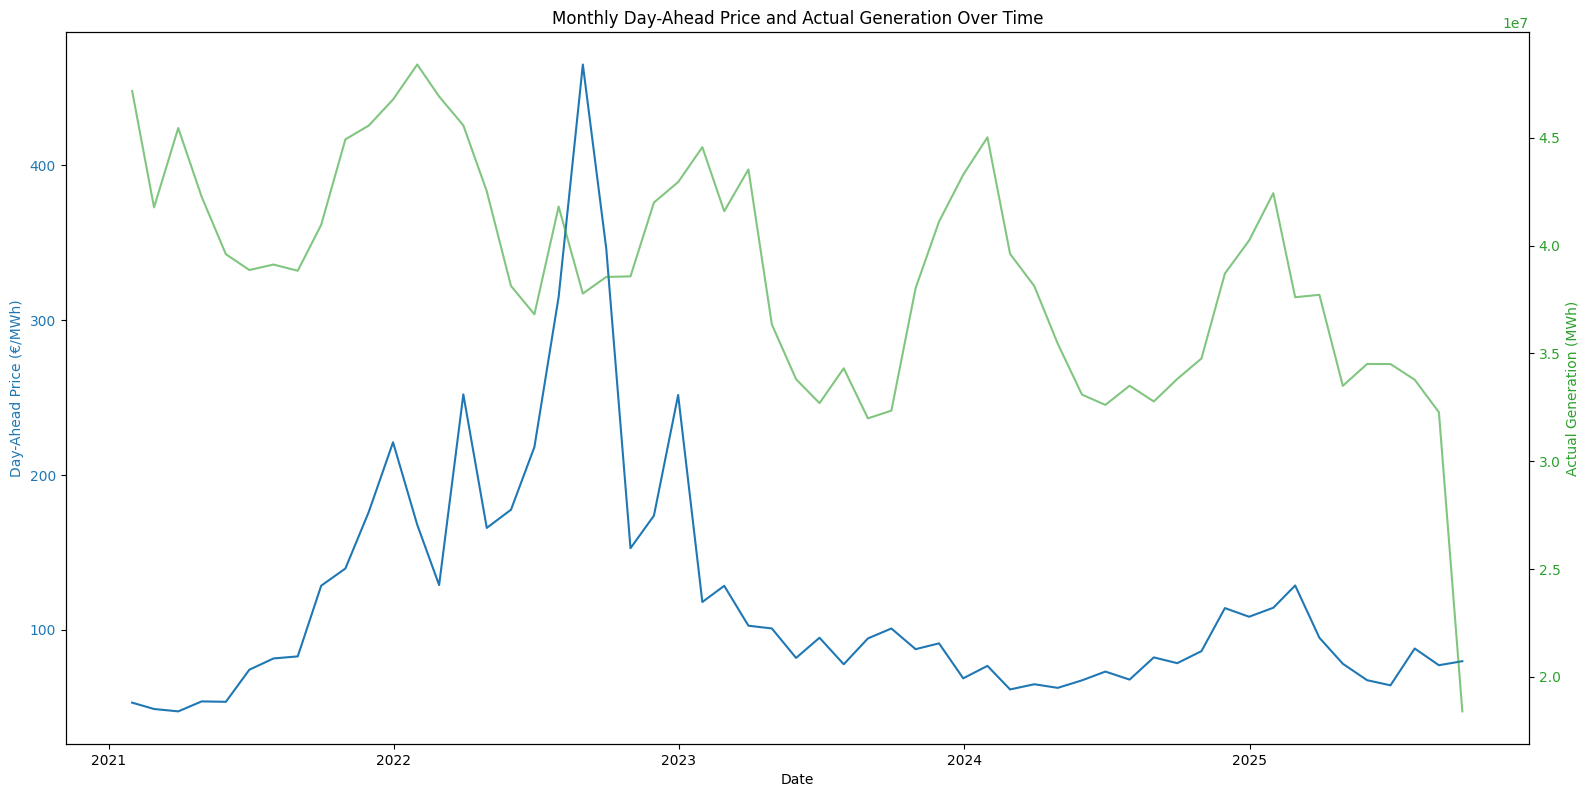

In [170]:
# Resample to monthly values (mean for price, sum for generation)
# Set datetime columns as index for resampling

day_ahead_prices_monthly = day_ahead_prices.set_index('Start date').resample('ME')\
    ["Germany/Luxembourg [€/MWh] Original resolutions"].mean()
actual_generation_monthly = actual_generation.set_index('Start date').resample('ME')\
    ["Total Generation [MWh]"].sum()

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Price on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Day-Ahead Price (€/MWh)', color=color)
ax1.plot(day_ahead_prices_monthly.index, day_ahead_prices_monthly.values, color=color, label='Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Generation
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Actual Generation (MWh)', color=color)
ax2.plot(
    actual_generation_monthly.index, 
    actual_generation_monthly.values, 
    color=color, alpha=0.6, 
    label='Generation')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Monthly Day-Ahead Price and Actual Generation Over Time')
plt.show()

#### Observation

- The plot above shows the monthly trend of day-ahead prices and total electricity generation. There is no clear inverse or direct relationship visible at a monthly level, suggesting other factors may influence price beyond total generation.


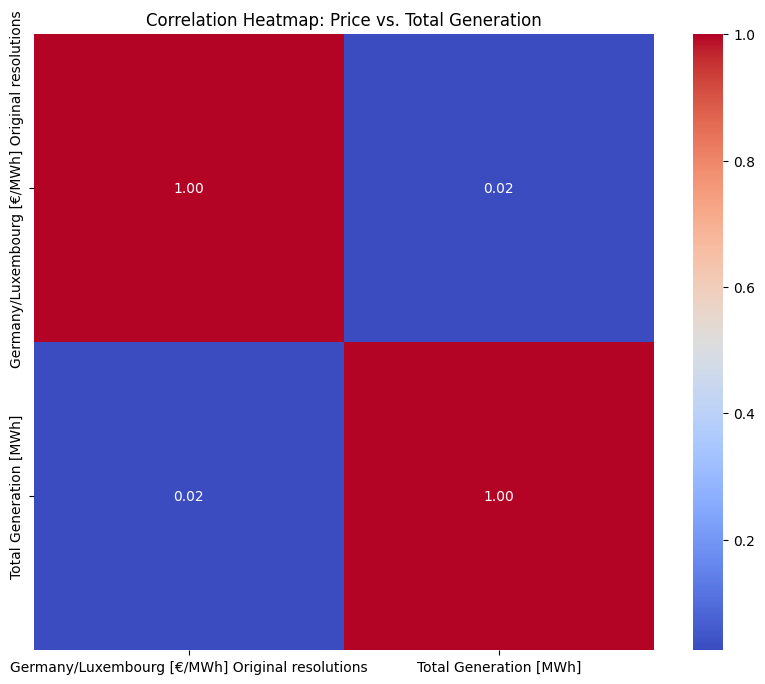

In [171]:
# Visualize correlation between total generation and day-ahead price
# Merge the two datasets on 'Start date' for correlation analysis
gen_vs_price_df = pd.merge(
    actual_generation[['Start date', 'Total Generation [MWh]']],
    day_ahead_prices[['Start date', 'Germany/Luxembourg [€/MWh] Original resolutions']],
    on='Start date'
)

plt.figure(figsize=(10, 8))
correlation_matrix = gen_vs_price_df[['Germany/Luxembourg [€/MWh] Original resolutions', 'Total Generation [MWh]']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Price vs. Total Generation')
plt.show()

### Result:

- Day-ahead price and actual total generation for the same timeframe are nearly uncorrelated (correlation coefficient ≈ 0.02).
- This suggests that other factors, such as demand, imports/exports, or market mechanisms, may play a larger role in price formation.
